In [69]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import cv2, mmcv
# confirm mtcnn was installed correctly
from facenet_pytorch import MTCNN
from IPython import display
import numpy as np
import face_recognition
import os

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [61]:
mtcnn = MTCNN(
    margin=40, min_face_size=40,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

In [15]:
p3 = Image.open("Patrick_JPEG3.jpg")

In [16]:
boxes, p = mtcnn.detect(p3)

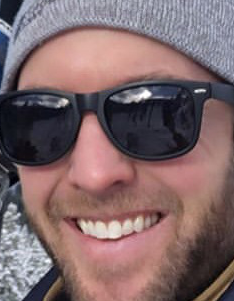

In [17]:
p3.crop(boxes[0])

In [25]:
def match_face_encodings(ke, ue):
    results = face_recognition.compare_faces([ke], ue)
    if results[0] == True:
        return True
    else:
        return False

In [47]:
def create_known_embedding(image_path):
    image = face_recognition.load_image_file(image_path)
    encoding = face_recognition.face_encodings(image)[0]
    person = image_path.split('/')[-1].split('.')[0]
    return (person, encoding)

In [28]:
known_images = ['patrick.jpg']

In [33]:
BUCKET = "s3://w251-vijay-s3/"
img_loc = BUCKET + "images/" + 'patrick.jpg'

In [34]:
cmd = "s3cmd put --force " + 'patrick.jpg' + ' ' + img_loc

In [35]:
import subprocess

In [36]:
print("Executing command {}".format(cmd))
subprocess.call(cmd, shell=True)

Executing command s3cmd put --force patrick.jpg s3://w251-vijay-s3/images/patrick.jpg


0

In [45]:
KNOWN_FACES = '/home/knowns/'

In [39]:
files = os.listdir(KNOWN_FACES)

In [49]:
known_people = {}
for file in files:
    person, encoding = create_known_embedding(KNOWN_FACES + file)
    known_people[person] = encoding

In [50]:
known_people

{'patrick': array([-0.09667683,  0.10449606,  0.11415446, -0.03423255, -0.09088294,
         0.00905249,  0.01234787, -0.09234898,  0.15370554, -0.05574076,
         0.21561287, -0.03769734, -0.3293941 ,  0.01573033,  0.02440108,
         0.14659411, -0.20009157, -0.12609577, -0.06712134, -0.07960277,
         0.07411384,  0.05589255, -0.05445645,  0.0384182 , -0.10359035,
        -0.32447791, -0.00877103, -0.12277521,  0.0660475 , -0.05973936,
         0.0369724 , -0.02958502, -0.17157297,  0.02788682,  0.01553717,
         0.01082208, -0.02792968, -0.13613684,  0.23452838, -0.05130035,
        -0.17916474, -0.00651999,  0.03280591,  0.20467652,  0.12091264,
         0.00924356,  0.03345697, -0.02083323,  0.1406343 , -0.29839894,
         0.10975298,  0.11254625,  0.18790655,  0.04465447,  0.09708989,
        -0.19544944, -0.05174653,  0.19510874, -0.25792003,  0.18909615,
         0.10740007, -0.10653876, -0.01247807, -0.11032872,  0.20288227,
         0.09193445, -0.17790112, -0.068

In [51]:
filename = "./package.mp4"

In [52]:
video = mmcv.VideoReader(filename)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

<class 'PIL.Image.Image'>


In [71]:
cropped_faces = []
person_list = []
count = 0
for k, frame in enumerate(frames):    
    # Detect faces
    boxes, p = mtcnn.detect(frame)
    for i in range(len(p)):
        if p[i] is not None and p[i] > 0.9:
            print("Person detected in frame: {}".format(k))
            person_list.append(k)
            count += 1
            face_crop = frame.crop(boxes[i])
            arr_img = np.array(face_crop)
            res = cv2.imwrite("test.jpg", arr_img)
            if not res:
                continue
            img = face_recognition.load_image_file('test.jpg')
            enc = face_recognition.face_encodings(img)
            # image not clear enough for encoding
            # save the image for future analysis
            if len(enc) == 0:
                continue
            print(enc[0])
            for k, v in known_people:
                print("Checking for {}".format(k))
                res = match_face_encodings(v, enc)
                if res:
                    print("{} is at the door!!".format(k))
                else:
                    print("An unknown person at the door!!")
            cropped_faces.append(face_crop)

#return count, person_list

Person detected in frame: 60
Person detected in frame: 69
Person detected in frame: 70
Person detected in frame: 71
Person detected in frame: 72
Person detected in frame: 73
Person detected in frame: 76
Person detected in frame: 77
Person detected in frame: 95


In [78]:
person_list

[60, 69, 70, 71, 72, 73, 76, 77, 95]

0 60
1 69
2 70
3 71
4 72
5 73
6 76
7 77
8 95


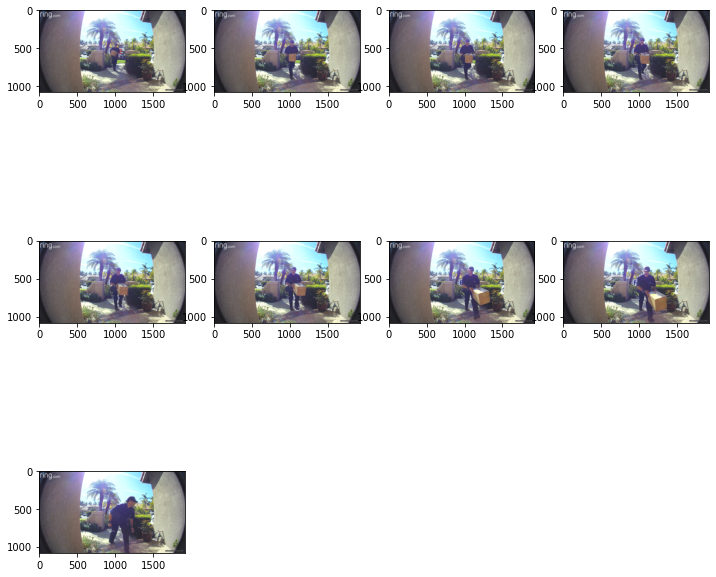

In [84]:
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = int(np.ceil(count/columns))
for i in range(0, count):
    img = frames[person_list[i]]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()